In [1]:
using Pkg
Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/Documents/GitHub/AMO-Single-Project`


In [2]:
using Pkg
Pkg.update()


    Updating registry at `~/.julia/registries/General.toml`


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


In [3]:
#import Pkg
Pkg.add("AxisArrays")
Pkg.add("JuMP")
Pkg.add("XLSX")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("AxisArrays")
Pkg.add("Statistics")
Pkg.add("PGFPlotsX")
Pkg.add("AxisArrays")
Pkg.add("CPLEX")
Pkg.add("HiGHS")
Pkg.add("CSV")
Pkg.add("Tables")

   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes 

to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/GitHub/AMO-Single-Project/Project.toml`
  No Changes to `~/Documents/GitHub/AMO-Single-Project/Manifest.toml`


In [4]:
using JuMP, XLSX, DataFrames, Plots, AxisArrays, Statistics, PGFPlotsX, CPLEX, HiGHS, CSV, Tables

In [5]:
pgfplotsx()

Plots.PGFPlotsXBackend()

# Read In And Prepare Data 

In [6]:
mydata = Dict{String, DataFrame}()

Dict{String, DataFrame}()

In [7]:
xl = XLSX.readxlsx("data/curtailmentinfonew.xlsx")
mydata["curtailmentinfo"] = DataFrame(XLSX.gettable(xl["curtailmentinfo"]; infer_eltypes=true))
print("curtailment data read in successfully")

curtailment data read in successfully

In [8]:
mydata["curtailmentinfo"]

Row,t,n,k,cost,min,max,SUC,costb,SUCb
,String,String,String,Int64,Float64,Float64,Int64,Int64,Int64
1,t12,n1,k1,15,0.51,0.56,20,10,15
2,t12,n1,k2,17,0.51,0.56,20,12,15
3,t12,n1,k3,19,0.51,0.56,20,14,15
4,t12,n2,k1,15,0.51,0.56,20,10,15
5,t12,n2,k2,17,0.51,0.56,20,12,15
6,t12,n2,k3,19,0.51,0.56,20,14,15
7,t12,n3,k1,15,0.51,0.56,20,10,15
8,t12,n3,k2,17,0.51,0.56,20,12,15
9,t12,n3,k3,19,0.51,0.56,20,14,15


In [9]:
xl = XLSX.readxlsx("data/generatorinfo.xlsx")
generatorinfo = XLSX.sheetnames(xl)
mydata["generatorinfo"] = DataFrame(XLSX.gettable(xl["generatorinfo"]; infer_eltypes=true))
print("generator data read in successfully")

generator data read in successfully

In [10]:
mydata["generatorinfo"]

Row,ID,location,cost,upresercost,dnresercost,cap,maxupresercap,maxdnresercap
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,g1,1,13.32,1.68,2.32,106.4,48.0,48.0
2,g2,2,13.32,1.68,2.32,106.4,48.0,48.0
3,g3,7,20.7,3.3,4.67,245.0,84.0,84.0
4,g4,13,20.93,4.07,3.93,413.7,216.0,216.0
5,g5,15,26.11,1.89,3.11,42.0,42.0,42.0
6,g6,15,10.52,5.48,3.52,108.5,36.0,36.0
7,g7,16,10.52,5.48,3.52,108.5,36.0,36.0
8,g8,18,6.02,4.98,5.02,280.0,60.0,60.0
9,g9,21,5.47,5.53,4.97,280.0,60.0,60.0


In [11]:
xl = XLSX.readxlsx("data/initdemand.xlsx")
initdemand = XLSX.sheetnames(xl)
mydata["initdemand"] = DataFrame(XLSX.gettable(xl["initdemand"]; infer_eltypes=true))
print("demand data read in successfully")

demand data read in successfully

In [12]:
mydata["initdemand"]

Row,t,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15,n16,n17,n18,n19,n20,n21,n22,n23,n24
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,t1,54.768,48.9,90.628,37.816,35.86,69.112,63.244,86.064,88.02,97.8,0.0,0.0,133.66,97.8,159.74,50.204,0.0,168.216,91.932,65.2,0.0,0.0,0.0,0.0
2,t2,52.332,46.725,86.597,36.134,34.265,66.038,60.431,82.236,84.105,93.45,0.0,0.0,127.715,93.45,152.635,47.971,0.0,160.734,87.843,62.3,0.0,0.0,0.0,0.0
3,t3,52.92,47.25,87.57,36.54,34.65,66.78,61.11,83.16,85.05,94.5,0.0,0.0,129.15,94.5,154.35,48.51,0.0,162.54,88.83,63.0,0.0,0.0,0.0,0.0
4,t4,48.72,43.5,80.62,33.64,31.9,61.48,56.26,76.56,78.3,87.0,0.0,0.0,118.9,87.0,142.1,44.66,0.0,149.64,81.78,58.0,0.0,0.0,0.0,0.0
5,t5,46.2,41.25,76.45,31.9,30.25,58.3,53.35,72.6,74.25,82.5,0.0,0.0,112.75,82.5,134.75,42.35,0.0,141.9,77.55,55.0,0.0,0.0,0.0,0.0
6,t6,46.2,41.25,76.45,31.9,30.25,58.3,53.35,72.6,74.25,82.5,0.0,0.0,112.75,82.5,134.75,42.35,0.0,141.9,77.55,55.0,0.0,0.0,0.0,0.0
7,t7,50.4,45.0,83.4,34.8,33.0,63.6,58.2,79.2,81.0,90.0,0.0,0.0,123.0,90.0,147.0,46.2,0.0,154.8,84.6,60.0,0.0,0.0,0.0,0.0
8,t8,53.76,48.0,88.96,37.12,35.2,67.84,62.08,84.48,86.4,96.0,0.0,0.0,131.2,96.0,156.8,49.28,0.0,165.12,90.24,64.0,0.0,0.0,0.0,0.0
9,t9,59.64,53.25,98.69,41.18,39.05,75.26,68.87,93.72,95.85,106.5,0.0,0.0,145.55,106.5,173.95,54.67,0.0,183.18,100.11,71.0,0.0,0.0,0.0,0.0


In [13]:
xl = XLSX.readxlsx("data/lineconstraints.xlsx")
linecontraints = XLSX.sheetnames(xl)
mydata["lineconstraints"] = DataFrame(XLSX.gettable(xl["lineconstraints"]; infer_eltypes=true))
print("line constraint data read in successfully")

line constraint data read in successfully

In [14]:
mydata["lineconstraints"]

Row,ID,from,to,X,flowcap
,String,Int64,Int64,Float64,Int64
1,l1,1,2,0.0146,175
2,l2,1,3,0.2253,175
3,l3,1,5,0.907,350
4,l4,2,4,0.1356,175
5,l5,2,6,0.205,175
6,l6,3,9,0.1271,175
7,l7,3,24,0.084,400
8,l8,4,9,0.111,175
9,l9,5,10,0.094,350


In [15]:
xl = XLSX.readxlsx("data/nodeinfo.xlsx")
nodeinfo = XLSX.sheetnames(xl)
mydata["nodeinfo"] = DataFrame(XLSX.gettable(xl["nodeinfo"]; infer_eltypes=true))
print("node data read in successfully")

node data read in successfully

In [16]:
mydata["nodeinfo"]

Row,ID,Num
,String,Int64
1,n1,1
2,n2,2
3,n3,3
4,n4,4
5,n5,5
6,n6,6
7,n7,7
8,n8,8
9,n9,9


In [17]:
xl = XLSX.readxlsx("data/shiftinginfonew.xlsx")
shiftinginfo = XLSX.sheetnames(xl)
mydata["shiftinginfo"] = DataFrame(XLSX.gettable(xl["shiftinginfo"]; infer_eltypes=true))
print("shifting information read in successfully")

shifting information read in successfully

In [18]:
mydata["shiftinginfo"]

Row,t,n,k,cost,min,max,costb
,String,String,String,Int64,Float64,Float64,Int64
1,t12,n1,k1,10,0.51,0.56,8
2,t12,n1,k2,12,0.51,0.56,10
3,t12,n1,k3,14,0.51,0.56,12
4,t12,n2,k1,10,0.51,0.56,8
5,t12,n2,k2,12,0.51,0.56,10
6,t12,n2,k3,14,0.51,0.56,12
7,t12,n3,k1,10,0.51,0.56,8
8,t12,n3,k2,12,0.51,0.56,10
9,t12,n3,k3,14,0.51,0.56,12


In [19]:
xl = XLSX.readxlsx("data/windfarminfo.xlsx")
windfarminfo = XLSX.sheetnames(xl)
mydata["windfarminfo"] = DataFrame(XLSX.gettable(xl["windfarminfo"]; infer_eltypes=true))
print("windfarm data read in successfully")

windfarm data read in successfully

In [20]:
mydata["windfarminfo"]

Row,ID,location,cap,forecast
,String,Int64,Int64,Float64
1,wf1,3,500,120.54
2,wf2,5,500,115.52
3,wf3,16,300,53.34
4,wf4,21,300,38.16


In [21]:
xl = XLSX.readxlsx("data/windscenarios.xlsx")
windscenarios = XLSX.sheetnames(xl)
mydata["windscenarios"] = DataFrame(XLSX.gettable(xl["windscenarios"]; infer_eltypes=true))
print("wind scenario data read in successfully")


wind scenario data read in successfully

In [22]:
mydata["windscenarios"]

Row,scenario,windfarm,wflocation,node,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24
,String,String,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,s0,wf1,3,n3,0.563373,0.556427,0.620064,0.565905,0.662963,0.672048,0.683556,0.690681,0.706195,0.655941,0.684012,0.701909,0.707423,0.705134,0.744796,0.763055,0.727549,0.695863,0.724753,0.771747,0.824357,0.782885,0.815081,0.751977
2,s0,wf2,5,n5,0.762555,0.816471,0.768671,0.767531,0.709601,0.733432,0.713545,0.755083,0.752244,0.716899,0.712946,0.729969,0.716462,0.738711,0.76327,0.758781,0.776659,0.736785,0.776178,0.794342,0.816367,0.899832,0.813165,0.778895
3,s0,wf3,16,n16,0.641406,0.714133,0.734266,0.784352,0.767632,0.740445,0.72134,0.693765,0.745427,0.760809,0.73836,0.757315,0.719177,0.753422,0.672017,0.704182,0.734911,0.763352,0.730289,0.765579,0.763751,0.729876,0.619155,0.58149
4,s0,wf4,21,n21,0.396813,0.393274,0.314061,0.400584,0.43328,0.372218,0.377994,0.418362,0.419582,0.39794,0.439299,0.410468,0.397242,0.40059,0.459773,0.410965,0.330264,0.446894,0.394118,0.393985,0.353184,0.408784,0.410033,0.391545
5,s0,wf1,3,n3,0.721771,0.732247,0.759537,0.788805,0.777572,0.745138,0.769833,0.773408,0.792901,0.784215,0.785262,0.757621,0.754372,0.777557,0.884843,0.790911,0.821157,0.80645,0.783256,0.777365,0.745908,0.751001,0.736325,0.683659
6,s1,wf2,5,n5,0.631953,0.703686,0.712237,0.754201,0.72398,0.693296,0.731701,0.74784,0.762398,0.780623,0.788395,0.748318,0.692081,0.721727,0.73404,0.706162,0.735412,0.717774,0.739614,0.739728,0.765892,0.750332,0.724517,0.687544
7,s1,wf3,16,n16,0.684535,0.719795,0.707353,0.746384,0.769346,0.766678,0.755131,0.769916,0.781495,0.766914,0.798253,0.782118,0.765404,0.780281,0.793258,0.824724,0.796428,0.768123,0.814361,0.827403,0.815508,0.838825,0.837876,0.700156
8,s1,wf4,21,n21,0.419462,0.431244,0.415342,0.397957,0.367345,0.385439,0.414496,0.398673,0.412223,0.417866,0.394065,0.444695,0.379643,0.372682,0.400285,0.423048,0.433025,0.380977,0.388475,0.407569,0.414777,0.439608,0.329721,0.398004
9,s2,wf1,3,n3,0.654747,0.695253,0.707639,0.712095,0.717151,0.729282,0.728227,0.748557,0.718312,0.760617,0.724435,0.691638,0.709339,0.684289,0.703084,0.718626,0.697616,0.722929,0.707437,0.776908,0.744131,0.766961,0.750614,0.744668


### Set generation

In [23]:
G = mydata["generatorinfo"][:, :ID]
L = mydata["lineconstraints"][:, :ID]
T = mydata["initdemand"][:, :t]          #times
N = mydata["nodeinfo"][:, :ID]
S = unique(mydata["windscenarios"][:, :scenario])
K = unique(mydata["curtailmentinfo"][:, :k])

NG = length(G)
NL = length(L)
NT = length(T)
NN = length(N)
NS = length(S)
NK = length(K)

3

# Prepare data

Prepare the generator information

In [24]:
#generatorinfo
generators = Dict{String, AxisArray}()
for c in names(mydata["generatorinfo"])
    help_array1 = AxisArray(mydata["generatorinfo"][:, c], g=G)
    # Assign the 'help_array1' AxisArray to the 'c' key in the 'generators' dictionary
    generators[c] = help_array1
end

Prepare all of the line constraints

In [25]:
#lineconstraints
#lines = Dict(c => AxisArray(mydata["lineconstraints"][:, c], l=L) for c in names(mydata["lineconstraints"]));
lines = Dict{String, AxisArray}()
for c in names(mydata["lineconstraints"])
    help_array2 = AxisArray(mydata["lineconstraints"][:, c], l=L)
    lines[c] = help_array2
end
B = AxisArray(zeros(NL, NN), l=L, n=N)
for l in L
    from_node = lines["from"][l]
    to_node = lines["to "][l]
    X = lines["X"][l]
    # Loop through each node.
    for (idn, node) in enumerate(N)
        if node == from_node
            B[l, idn] = -1/X
        elseif node == to_node
            B[l, idn] = 1/X
        end
    end
end 


Prepare the data of the initial demand (demand before DR)

In [26]:
#initdemand
load = AxisArray(Matrix(mydata["initdemand"][:, Not(:t)]), t=T, n=N)
cost_ls = 100.0

100.0

Prepare the load shifiting information

In [27]:
#shiftinginfo
cols = names(mydata["shiftinginfo"][:, Not(["t", "n", "k"])])
#DRSd = Dict(c => AxisArray(zeros(NT, NN, NK), t=T, n=N, k=K) for c in cols)

DRSd = Dict{String, AxisArray}()
for c in cols
# Loop through the column names and create a new AxisArray for each column
    help_array3 = AxisArray(zeros(NT, NN, NK), t=T, n=N, k=K)
    DRSd[c] = help_array3
end
# Loop through each row in "shiftinginfo" and assign the values to the corresponding AxisArray in DRSd
for r in eachrow(mydata["shiftinginfo"])
    for c in cols
        DRSd[c][r[:t], r[:n], r[:k]] = r[c]
    end
end

Prepare the load curtailment information

In [28]:
#curtailmentinfo
cols = names(mydata["curtailmentinfo"][:, Not(["t", "n", "k"])])

#DRCd = Dict(c => AxisArray(zeros(NT, NN, NK), t=T, n=N, k=K) for c in cols)
DRCd = Dict{String, AxisArray}()
for c in cols
    help_array4 = AxisArray(zeros(NT, NN, NK), t=T, n=N, k=K)
    DRCd[c] = help_array4
end
# Iterate over each row in the curtailmentinfo data
for r in eachrow(mydata["curtailmentinfo"])
    for c in cols
        DRCd[c][r[:t], r[:n], r[:k]] = r[c]
    end
end


In [29]:
DRCd

Dict{String, AxisArray} with 6 entries:
  "cost"  => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …
  "SUC"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …
  "max"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …
  "min"   => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …
  "costb" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …
  "SUCb"  => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 …

Prepare the information of the location of the nodes and generators

In [30]:
#location

# Create an AxisArray where ng[n,g] = 1 if generator g is located at node n, and 0 otherwise
ng = AxisArray(
    [[g for g in G if generators["location"][g] == idn] for (idn, n) in enumerate(N)],
    n = N
)
#node

# Create an AxisArray where nl[n,l] = 1 if line l originates at node n, -1 if it terminates at node n, and 0 otherwise
nl = AxisArray(zeros(Int, NN, NL), n=N, l=L)
for l in L
    nl[N[lines["from"][l]], l] = 1
    nl[N[lines["to "][l]], l] = -1
end

In [31]:
windCap = AxisArray(zeros(NN), n=N)
windCapDict = Dict("n3" => 500.0, "n5" => 500.0, "n16" => 300.0, "n21" => 300.0)

# populate the windCap AxisArray with the capacities 
windCap["n3"] = 500.0
windCap["n5"] = 500.0
windCap["n16"] = 300.0
windCap["n21"] = 300.0

pi = AxisArray(ones(NS)/NS, s=S)

wind = AxisArray(zeros(NS, NN, NT), s=S, n=N, t=T)
# populate the wind array with the wind power generation data from the input data, scale
for r in eachrow(mydata["windscenarios"])
    for t in T
        wind[r[:scenario], r[:node], t] = r[t]*windCap[r[:node]]
    end
end

estwind = mean(wind, dims=1)[1, :, :]
stdwind = std(wind, dims=1)[1, :, :]
cost_ws = 20.0


20.0

In [32]:
pi

1-dimensional AxisArray{Float64,1,...} with axes:
    :s, ["s0", "s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9"]
And data, a 10-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [ ]:
# total_cost = 0.0
# for t in T
#     generator_cost = 0.0
#     reserve_cost = 0.0
#     start_cost = 0.0
    
#     # Generator cost
#     for g in G
#         generator_cost += PGen[g,t] * generators["cost"][g] +
#                             r_up[g,t] * generators["upresercost"][g] +
#                             r_down[g,t] * generators["dnresercost"][g] +
#                             suc[findfirst(isequal(t), T),g]
#     end
    
#     # Reserve cost
#     for n in N
#         reserve_cost += DRC[t, n] + DRS[t, n]
#     end
    
#     # Startup cost
#     for s in S
#         startup_cost = 0.0
#         for g in G
#             startup_cost += generators["cost"][g] * (r_ups[s,g,t]-r_downs[s,g,t])
#         end
#         start_cost += pi[s] * (startup_cost + sum(cost_ws * Wspill[s,n,t] + cost_ls * Lshed[s,n,t] for n in N))
#     end
    
#     # Total cost
#     total_cost += generator_cost + reserve_cost + start_cost
# end


# Model

Variables: 

pgen: the scheduled generation output for each generator g at each time t

u: the state of each generator g (on or off) at each time t

θ0: the phase angles for each node n in the power network during the scheduling phase

θ1: the phase angles for each node n during the balancing phase and each scenario s

Wsc: the scheduled wind power for each node n at each time t

r_up and r_down: the up and down regulation reserves for each generator g at each time t

r_ups and r_downs: the actual up and down regulation provided by each generator g at each time t

Lshed: the amount of load shedding at each node n during each scenario s and time t

Wspill: the amount of wind spillage at each node n during each scenario s and time t

suc: the start-up/shut-down costs for each generator g at each time t


Expressions: 
DRC, DRS, DBC, DBS: the costs/profits associated with demand response contracts
pflow0: the power flow on each transmission line during the scheduling phase
pflow1: the power flow on each transmission line during the balancing phase and each scenario s


Objective is to minimize totalcost
totalcost: the total cost of the system, including the cost of generation, reserves, start-up/shut-down, load shedding, wind spillage, and demand response

The model is intended to represent an electric power system with wind power and demand response (DR) programs.



Generator Limits:
a. The power generated by a generator at time t, plus any upward regulation, should be less than or equal to the generator's capacity times its availability.
b. The upward regulation should be less than or equal to the generator's maximum upward reserve capacity.
c. The downward regulation should be less than or equal to the generator's maximum downward reserve capacity.

Reserve Limits:
The net power generation from all generators connected to a node, plus the power injection from any energy storage system connected to the node, plus the scheduled curtailment of any DR resource, should be equal to the total demand at that node plus any power flow into the node from transmission lines.

Transmission Line Limits:
The power flow through a transmission line at time t should be less than or equal to the line's capacity, and greater than or equal to the negative of the line's capacity.



DR Curtailment Constraints (between ISO and DR aggregator):
a. The scheduled curtailment of a DR resource at time t should be less than or equal to the maximum curtailment allowed for that resource multiplied by its availability.
b. The scheduled curtailment of a DR resource at time t should be greater than or equal to the minimum curtailment allowed for that resource multiplied by its availability.


DR Shifting Constraints (between ISO and DR aggregator):
a. The scheduled shifting of a DR resource at time t should be less than or equal to the maximum shifting allowed for that resource multiplied by its availability.
b. The scheduled shifting of a DR resource at time t should be greater than or equal to the minimum shifting allowed for that resource multiplied by its availability.
c. The scheduled reverse shifting of a DR resource at time t should be less than or equal to the maximum reverse shifting allowed for that resource multiplied by its availability.


DR Curtailment Constraints (between DR aggregator and customer):
a. The scheduled curtailment of a DR resource at time t should be less than or equal to the maximum curtailment allowed for that resource multiplied by its availability.
b. The scheduled curtailment of a DR resource at time t should be greater than or equal to the minimum curtailment allowed for that resource multiplied by its availability.


DR Shifting Constraints (between DR aggregator and customer):
a. The scheduled shifting of a DR resource at time t should be less than or equal to the maximum shifting allowed for that resource multiplied by its availability.
b. The scheduled shifting of a DR resource at time t should be greater than or equal to the minimum shifting allowed for that resource multiplied by

In [33]:
bdr = Model(CPLEX.Optimizer)
set_silent(bdr)

@variable(bdr, PGen[G, T] >= 0) # scheduled generator output for each generator g at each time t
@variable(bdr, u[G, T], Bin) # state of each generator g (on or off) at each time 
@variable(bdr, θ0[N, T]) # the phase angles for each node n in the power network during the scheduling phase
@variable(bdr, θ1[N, S, T]) # the phase angles for each node n in the power network during the balancing phase and each scenario s
@variable(bdr, Wsc[N, T] >= 0)# the scheduled wind power for each node n at each time t 
@variable(bdr, r_up[G, T] >= 0) # up regulation reserves for each generator g at each time t
@variable(bdr, r_down[G, T] >= 0) # down regulation reserves for each generator g at each time t
@variable(bdr, r_ups[S, G, T] >= 0) # actual up regulation provided by each generator g at each time t
@variable(bdr, r_downs[S, G, T] >= 0) # actual down regulation provided by each generator g at each time t
@variable(bdr, Lshed[S, N, T] >= 0) # amount of load shedding at each node n at each time t
@variable(bdr, Wspill[S, N, T] >= 0) # the amount of wind power spilled at each node n at each time t
@variable(bdr, suc[1:NT, G] >= 0) # start-up/shut-down cost for each generator g at each time t

    # DR contracts
    # DR agg <> ISO contract parameters
@variable(bdr, DRCK[T, N, K] >= 0) # DR curtailment blocks
@variable(bdr, DRSK[T, N, K] >= 0) # DR shifting blocks
@variable(bdr, DRC_SU[T, N, K] >= 0) # DRC startup cost
@variable(bdr, DRSRK[T, N, K] >= 0) # DR recovery blocks
@variable(bdr, uDRC[T, N, K], Bin) # DR curtailment active
@variable(bdr, uDRS[T, N, K], Bin) # DR shifting activate
@variable(bdr, yDR[T, N, K], Bin) # DRC activated
@variable(bdr, zDR[T, N, K], Bin) # DRC de-activated
@variable(bdr, uDRSR[T, N, K], Bin) # DRS recovery active
    # same for DR agg <> cust. contracts
@variable(bdr, DBCK[T, N, K] >= 0)
@variable(bdr, DBSK[T, N, K] >= 0)
@variable(bdr, DBC_SU[T, N, K] >= 0) 
@variable(bdr, DBSRK[T, N, K] >= 0)
@variable(bdr, uDBC[T, N, K], Bin)
@variable(bdr, uDBS[T, N, K], Bin)
@variable(bdr, yDB[T, N, K], Bin)
@variable(bdr, zDB[T, N, K], Bin)
@variable(bdr, uDBSR[T, N, K], Bin)
    # Dual multipliers/linearization variables for the Karush-Kuhn-Tucker conditions
@variable(bdr, Α[T,N,K] >= 0)
@variable(bdr, Β[T,N,K] >= 0)
@variable(bdr, Δ[T,N,K] >= 0)
@variable(bdr, Ε[T,N,K] >= 0)
@variable(bdr, Ζ[T,N,K] >= 0)
@variable(bdr, Η[T,N,K] >= 0)
@variable(bdr, Ι[T,N,K] >= 0)
@variable(bdr, Κ[T,N,K] >= 0)
@variable(bdr, Λ[T,N,K] >= 0)
@variable(bdr, Μ[T,N,K] >= 0)


# fix slack bus
fix.(θ0["n1", :], 0);
fix.(θ1["n1", :, :], 0);


@expression(bdr, DRC[t in T, n in N], sum(DRCd["cost"][t,n,k]*DRCK[t, n, k]+DRC_SU[t,n,k] for k in K))
@expression(bdr, DRS[t in T, n in N], sum(DRSd["cost"][t,n,k]*DRSK[t, n, k] for k in K))
@expression(bdr, DBC[t in T, n in N], sum(DRCd["costb"][t,n,k]*DBCK[t, n, k] for k in K))
@expression(bdr, DBS[t in T, n in N], sum(DRSd["costb"][t,n,k]*DBSK[t, n, k] for k in K))
@expression(bdr, pflow0[l in L, t in T], sum(B[l,n]*θ0[n,t] for n in N))
@expression(bdr, pflow1[l in L, s in S, t in T], sum(B[l,n]*θ1[n,s,t] for n in N))

# Generator Limits 

@constraint(bdr, pup[g in G, t in T], PGen[g, t] + r_up[g, t] <= generators["cap"][g] * u[g,t])

@constraint(bdr, res_up[g in G, t in T], r_up[g, t] <= generators["maxupresercap"][g])

@constraint(bdr, res_dn[g in G, t in T], r_down[g, t] <= generators["maxdnresercap"][g])

# Equality constraint

@constraint(bdr, bal0[n in N, t in T], sum(PGen[g,t] for g in ng[n]) + Wsc[n,t] + sum(DRCK[t,n,k] + DRSK[t,n,k] - DRSRK[t,n,k] for k in K) == load[t,n] + sum(pflow0[l, t]*nl[n,l] for l in L))

# Transmission Line Limits

@constraint(bdr, pfmax0[l in L, t in T], pflow0[l, t] <= lines["flowcap"][l])

@constraint(bdr, pfmin0[l in L, t in T], pflow0[l, t] >= -lines["flowcap"][l])

# DR curtailment constraints between ISO and Aggregator

@constraint(bdr, drcmax[t in T, n in N, k in K], DRCK[t,n,k] <= uDRC[t,n,k] * DRCd["max"][t,n,k]  )

@constraint(bdr, drcmin[t in T, n in N, k in K], DRCK[t,n,k] >= uDRC[t,n,k] * DRCd["min"][t,n,k])

@constraint(bdr, drcst1[τ in 2:NT, n in N, k in K], yDR[T[τ],n,k] - zDR[T[τ],n,k] == uDRC[T[τ],n,k] - uDRC[T[τ-1],n,k])

@constraint(bdr, drcst2[t in T, n in N, k in K], yDR[t,n,k] + zDR[t,n,k] <= 1)

@constraint(bdr, drcst3[t in T, n in N, k in K], DRC_SU[t,n,k] >= DRCd["SUC"][t,n,k] * yDR[t,n,k])

# DR shifting constraints between ISO and Aggregator

@constraint(bdr, drsmax[t in T, n in N, k in K], DRSK[t,n,k] <= uDRS[t,n,k] * DRSd["max"][t,n,k])

@constraint(bdr, drsmin[t in T, n in N, k in K], DRSK[t,n,k] >= uDRS[t,n,k] * DRSd["min"][t,n,k])

@constraint(bdr, drsmxr[t in T, n in N, k in K], DRSRK[t,n,k] <= 2*uDRSR[t,n,k])

@constraint(bdr, drsorr[t in T, n in N, k in K], uDRS[t,n,k] + uDRSR[t,n,k] <= 1)

@constraint(bdr, drbbal[n in N, k in K], sum(DRSRK[t,n,k] for t in T) == sum(DRSK[t,n,k] for t in T))

# DR curtailment constraints between Aggregator and Customer

@constraint(bdr, dbcmax[t in T, n in N, k in K], DBCK[t,n,k] <= uDRC[t,n,k] * DRCd["max"][t,n,k])

@constraint(bdr, dbcmin[t in T, n in N, k in K], DBCK[t,n,k] >= uDRC[t,n,k] * DRCd["min"][t,n,k])

@constraint(bdr, dbcst1[τ in 2:NT, n in N, k in K], yDB[T[τ],n,k] - zDB[T[τ],n,k] == uDBC[T[τ],n,k] - uDBC[T[τ-1],n,k])

@constraint(bdr, dbcst2[t in T, n in N, k in K], yDB[t,n,k] + zDB[t,n,k] <= 1)

@constraint(bdr, dbcst3[t in T, n in N, k in K], DBC_SU[t,n,k] >= DRCd["SUCb"][t,n,k] * yDB[t,n,k])

# DR shifting constraints between Aggregator and Customer

@constraint(bdr, dbsmax[t in T, n in N, k in K], DBSK[t,n,k] <= uDBS[t,n,k] * DRSd["max"][t,n,k])

@constraint(bdr, dbsmin[t in T, n in N, k in K], DBSK[t,n,k] >= uDBS[t,n,k] * DRSd["min"][t,n,k])

@constraint(bdr, dbsmxr[t in T, n in N, k in K], DBSRK[t,n,k] <= 2*uDBSR[t,n,k])

@constraint(bdr, dbsorr[t in T, n in N, k in K], uDBS[t,n,k] + uDBSR[t,n,k] <= 1)

@constraint(bdr, dbbbal[n in N, k in K], sum(DBSRK[t,n,k] for t in T) == sum(DBSK[t,n,k] for t in T))

# linearization constraints

@constraint(bdr, conAB[t in T, n in N, k in K], Α[t,n,k]-Β[t,n,k] >= DRCd["cost"][t,n,k])

@constraint(bdr, conDE[t in T, n in N, k in K], Δ[t,n,k]-Ε[t,n,k] >= DRSd["cost"][t,n,k])

@constraint(bdr, conHI[t in T, n in N, k in K], Η[t,n,k]-Ι[t,n,k] >= -DRCd["costb"][t,n,k])

@constraint(bdr, conKL[t in T, n in N, k in K], Κ[t,n,k]-Λ[t,n,k] >= -DRSd["costb"][t,n,k])

@constraint(bdr, strong_duality, 
    sum(
        Α[t,n,k]*DRCd["max"][t,n,k] - Β[t,n,k]*DRCd["min"][t,n,k] +
        Δ[t,n,k]*DRSd["max"][t,n,k] - Ε[t,n,k]*DRSd["min"][t,n,k] +
        Ζ[t,n,k]*2 +
        Η[t,n,k]*DRCd["max"][t,n,k] - Ι[t,n,k]*DRCd["min"][t,n,k] +
        Κ[t,n,k]*DRSd["max"][t,n,k] - Λ[t,n,k]*DRSd["min"][t,n,k] +
        Μ[t,n,k]*2
    for t in T for n in N for k in K) ==
    sum(
        DRCd["cost"][t,n,k] * DRCK[t,n,k] +
        DRSd["cost"][t,n,k] * DRSK[t,n,k] - 
        DRCd["costb"][t,n,k] * DBCK[t,n,k] - 
        DRSd["costb"][t,n,k] * DBSK[t,n,k]    
    for t in T for n in N for k in K))

# wind 

@constraint(bdr, resup[s in S, g in G, t in T], r_ups[s,g,t] <= r_up[g,t])

@constraint(bdr, resdn[s in S, g in G, t in T], r_downs[s,g,t] <= r_down[g,t])

@constraint(bdr, bals[s in S, n in N, t in T], 
    sum(r_ups[s,g,t]-r_downs[s,g,t] for g in ng[n]) + 
    wind[s,n,t] - Wsc[n,t] - Wspill[s,n,t] + Lshed[s,n,t] == 
    -sum((pflow1[l,s,t] - pflow0[l,t])*nl[n,l] for l in L))

@constraint(bdr, windspill[s in S, n in N, t in T], Wspill[s,n,t] <= wind[s,n,t])

@constraint(bdr, pfmax1[l in L, s in S, t in T], pflow1[l,s,t] <= lines["flowcap"][l])

@constraint(bdr, pfmin1[l in L, s in S, t in T], pflow1[l,s,t] >= -lines["flowcap"][l])


    
@objective(bdr, Min, 
sum(
    sum(
        PGen[g,t] * generators["cost"][g] +
        r_up[g,t] * generators["upresercost"][g] +
        r_down[g,t] * generators["dnresercost"][g] +
        suc[findfirst(isequal(t), T),g]
    for g in G) +
    sum(DRC[t, n] + DRS[t, n] for n in N) +
    sum(
        pi[s] * (
            sum(generators["cost"][g] * (r_ups[s,g,t]-r_downs[s,g,t]) for g in G) +
            sum(cost_ws * Wspill[s,n,t] + cost_ls * Lshed[s,n,t] for n in N)
            )
    for s in S)
for t in T)
)

bdr

A JuMP Model
Minimization problem with:
Variables: 74016
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 9793 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 26256 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 38640 constraints
`VariableRef`-in-`MathOptInterface.EqualTo{Float64}`: 264 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 50112 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 17568 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: CPLEX
Names registered in the model: DBC, DBCK, DBC_SU, DBS, DBSK, DBSRK, DRC, DRCK, DRC_SU, DRS, DRSK, DRSRK, Lshed, PGen, Wsc, Wspill, bal0, bals, conAB, conDE, conHI, conKL, dbbbal, dbcmax, dbcmin, dbcst1, dbcst2, dbcst3, dbsmax, dbsmin, dbsmxr, dbsorr, drbbal, drcmax, drcmin, drcst1, drcst2, drcst3, drsmax, drsmin, drsmxr, drsorr, pflow0, pflow1, pfmax0, pfmax1, pfmin0, pfmin1, pup, r_down, r_downs, r_up, r_ups

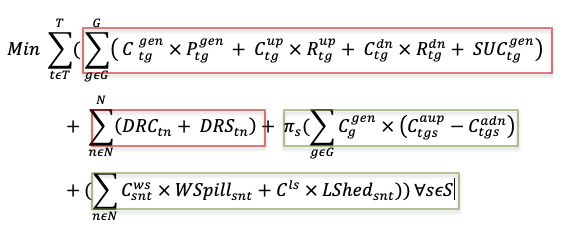

In [34]:
display("image/png", read("data/Objective Function.png"))

# Model

In [35]:
optimize!(bdr)

In [36]:
termination_status(bdr)

OPTIMAL::TerminationStatusCode = 1

In [37]:
objective_value(bdr)

2.4404489006975368e6

In [38]:
LoadBeforeDR = sum(load, dims=2)[:, 1]
for i=1:size(LoadBeforeDR,1)            
    println(LoadBeforeDR[i,:])        
end

[1438.964]
[1374.961]
[1390.4099999999999]
[1280.06]
[1213.8500000000001]
[1213.8500000000001]
[1324.1999999999998]
[1412.4799999999998]
[1566.97]
[1721.4599999999998]
[1787.67]
[1809.7400000000002]
[1875.9499999999998]
[1831.8099999999997]
[1864.9150000000002]
[1931.125]
[2162.86]
[2207.0]
[2118.7200000000003]
[2008.37]
[1875.9499999999998]
[1721.4599999999998]
[1600.0749999999998]
[1434.5500000000002]


In [39]:
LoadAfterDR = [sum(load[t,:]) - sum(value.(DRCK[t,:,:]) .+ value.(DRSK[t,:,:]) .- value.(DRSRK[t,:,:])) for t in T]
LoadAfterDR
for i=1:size(LoadAfterDR,1)            
    println(LoadAfterDR[i,:])        
end

[1497.634]
[1411.5810000000001]
[1412.8899999999999]
[1301.1799999999998]
[1233.2700000000002]
[1221.8100000000002]
[1329.6999999999998]
[1421.3800000010003]
[1573.383333332331]
[1728.0900000000001]
[1792.15]
[1751.8366666666686]
[1822.53]
[1770.4099999999999]
[1803.365]
[1877.485]
[2108.6699999999996]
[2152.21]
[2063.0299999999997]
[1953.2399999999998]
[1879.95]
[1724.0900000000001]
[1603.1949999999997]
[1436.0600000000002]


In [164]:
plot(
    LoadBeforeDR,
    label = "Load Before DR",
    xlabel = "Time",
    ylabel = "Load",
    xlims = (1, 24),
    xticks = 1:24,
)

plot!(
    LoadAfterDR,
    label = "Load After DR",
    xlabel = "Time",
    ylabel = "Load",
    xlims = (1, 24),
    xticks = 1:24,
)